In [2]:
import pandas as pd
import numpy as np
import sqlite3

import sys
sys.path.append("../")

from src.cmesrc.config import CMESRC_DB

from src.cmesrc.config import FLARES_MATCHED_TO_HARPS_PICKLE, DIMMINGS_MATCHED_TO_HARPS_PICKLE, LASCO_CME_DATABASE, MAIN_DATABASE_PICKLE, SPATIOTEMPORAL_MATCHING_HARPS_DATABASE_PICKLE, RAW_DIMMINGS_CATALOGUE
import matplotlib.pyplot as plt

In [3]:
con = sqlite3.connect(CMESRC_DB)
con.execute("PRAGMA foreign_keys = ON")
cur = con.cursor()

In [63]:
flares = pd.read_pickle(FLARES_MATCHED_TO_HARPS_PICKLE)
flares.replace({np.nan: None}, inplace=True)
# Print columns and data type
print(flares.dtypes)


HARPNUM                int64
FLARE_ID               int64
FLARE_DATE            object
FLARE_LON             object
FLARE_LAT             object
FLARE_CLASS_SCORE     object
FLARE_CLASS           object
FLARE_AR               int64
FLARE_AR_SOURCE       object
FLARE_VERIFICATION    object
dtype: object


In [64]:
# Show all tables
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('harps',), ('harps_bbox',), ('images',), ('pixel_values',), ('pixels',), ('x_pixel_values',), ('y_pixel_values',), ('harps_pixel_bbox',), ('harps_pixel_bbox_sizes',), ('cutouts_for_download',), ('flares',), ('dimmings',), ('cmes',), ('cmes_harpnums',)]


In [67]:
cur.execute("DROP TABLE IF EXISTS cmes_harpnums")
cur.execute("DROP TABLE IF EXISTS flares")

cur.execute("""
    CREATE TABLE IF NOT EXISTS flares (
        flare_id INTEGER NOT NULL PRIMARY KEY,
        HARPNUM INTEGER REFERENCES harps (harpnum),
        flare_date TEXT NOT NULL,
        flare_lon REAL ,
        flare_lat REAL,
        flare_class_score REAL NOT NULL,
        flare_class TEXT NOT NULL,
        flare_ar INTEGER,
        flare_ar_source TEXT,
        flare_verification TEXT
        CHECK (
        (flare_ar IS NULL AND flare_lon IS NOT NULL AND flare_lat IS NOT NULL) OR
        (flare_ar IS NOT NULL)
        )
        )
""")

In [68]:
nodupflares = flares.drop_duplicates(subset=["FLARE_ID"], keep="first")
print(len(nodupflares), len(nodupflares[nodupflares["FLARE_CLASS_SCORE"]>25]))

12580 1626


In [69]:
# Now we need to add the rows

# Drop duplicates
for i, row in flares.drop_duplicates(subset=["FLARE_ID"], keep="first").iterrows():
    cur.execute(
        """
        INSERT INTO flares (flare_id, HARPNUM, flare_date, flare_lon, flare_lat, flare_class_score, flare_class, flare_ar, flare_ar_source, flare_verification)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        """,
        (
            int(row["FLARE_ID"]),
            int(row["HARPNUM"]),
            row["FLARE_DATE"].iso[:-4],
            row["FLARE_LON"],
            row["FLARE_LAT"],
            row["FLARE_CLASS_SCORE"],
            row["FLARE_CLASS"],
            row["FLARE_AR"],
            row["FLARE_AR_SOURCE"],
            row["FLARE_VERIFICATION"]
        )
    )

In [70]:
con.commit()

In [99]:
raw_dimmings = pd.read_csv(RAW_DIMMINGS_CATALOGUE)

raw_dimmings = raw_dimmings

raw_dimmings.dropna(subset=["longitude", "latitude"], inplace=True)


len(raw_dimmings)

4541

In [71]:
dimmings = pd.read_pickle(DIMMINGS_MATCHED_TO_HARPS_PICKLE)
dimmings.replace({np.nan: None}, inplace=True)
# Print columns and data type
print(dimmings.dtypes)

dimming_id                    int64
start_time                   object
end_time                     object
last_detection_time          object
half_value_time              object
max_detection_time           object
sequences                     int64
max_detection_ratio         float64
f_r                         float64
avg_x                       float64
avg_y                       float64
avg_r                       float64
avg_num_pixels              float64
max_num_pixels                int64
longitude                   float64
latitude                    float64
total_intensity             float64
avg_intensity               float64
avg_median_intensity_abs    float64
HARPNUM                       int64
DIMMING_HARPNUM_ID           object
HARPS_RAW_LONDTMIN          float64
HARPS_RAW_LATDTMIN          float64
HARPS_RAW_LONDTMAX          float64
HARPS_RAW_LATDTMAX          float64
HARPS_RAW_DATE               object
HARPS_DIMMING_DISTANCE      float64
POSITION_SCORES             

In [102]:
len(dimmings[dimmings["MATCH"]])

2591

In [72]:
cur.execute("DROP TABLE IF EXISTS dimmings")

cur.execute("""
    CREATE TABLE IF NOT EXISTS dimmings (
        dimming_id INTEGER NOT NULL PRIMARY KEY,
        harpnum INTEGER REFERENCES harps (harpnum),
        harps_dimming_dist REAL NOT NULL,
        dimming_start_date TEXT NOT NULL,
        dimming_peak_date TEXT NOT NULL,
        dimming_lon REAL NOT NULL,
        dimming_lat REAL NOT NULL
    );
""")

In [73]:
# Now need to add the dimmings

for i, row in dimmings[dimmings["MATCH"]].iterrows():
    cur.execute(
        """
        INSERT INTO dimmings (dimming_id, harpnum, harps_dimming_dist, dimming_start_date, dimming_peak_date, dimming_lon, dimming_lat)
        VALUES (?, ?, ?, ?, ?, ?, ?)
        """,
        (
            int(row["dimming_id"]),
            int(row["HARPNUM"]),
            row["HARPS_DIMMING_DISTANCE"],
            row["start_time"].split(".")[0],
            row["max_detection_time"].iso[:-4],
            row["longitude"],
            row["latitude"]
        )
    )

In [74]:
con.commit()

In [75]:
cmes = pd.read_csv(LASCO_CME_DATABASE)
cmes.replace({np.nan: None}, inplace=True)
# Print columns and data type
print(cmes.dtypes)

CME_ID                         object
CME_DATE                       object
CME_PA                         object
CME_WIDTH                       int64
CME_LINEAR_SPEED               object
CME_2ND_ORDER_INITIAL_SPEED    object
CME_2ND_ORDER_FINAL_SPEED      object
CME_2ND_ORDER_20R_SPEED        object
CME_ACCELERATION               object
CME_MASS                       object
CME_KINETIC_ENERGY             object
CME_MPA                         int64
CME_HALO                        int64
CME_SEEN_IN                     int64
CME_QUALITY                     int64
CME_THREE_POINTS                int64
dtype: object


In [76]:
no_poor_cmes = cmes[cmes["CME_QUALITY"] == 0]
len(no_poor_cmes)

13311

In [10]:
# I want to know for how many CMEs there are matching HARPs

spat_harps = pd.read_pickle(SPATIOTEMPORAL_MATCHING_HARPS_DATABASE_PICKLE)
print(spat_harps[spat_harps["HARPS_SPAT_CONSIST"]]["CME_ID"].unique().shape, spat_harps["CME_ID"].unique().shape)

(14968, 34) (4139,)


In [13]:
spat_harps[~spat_harps["HARPS_SPAT_CONSIST"]][["CME_ID", "HARPNUM"]].head(10)

,CME_ID,HARPNUM
CME_HARPNUM_ID,,
ID201005010048055,ID20100501004805,5
ID201005010048056,ID20100501004805,6
ID201005010712055,ID20100501071205,5
ID201005010712056,ID20100501071205,6
ID201005021930051,ID20100502193005,1
ID201005021930052,ID20100502193005,2
ID201005021930058,ID20100502193005,8
ID201005031331411,ID20100503133141,1
ID201005031331412,ID20100503133141,2


In [7]:
cur.execute("DROP TABLE IF EXISTS spat_consist_harpnums")

cur.execute("""
    CREATE TABLE IF NOT EXISTS spat_consist_harpnums (
        harpnum INTEGER REFERENCES harps (harpnum),
        cme_id INTEGER REFERENCES cmes (cme_id),
        PRIMARY KEY (harpnum, cme_id)
        )
        """)


for idx, row in spat_harps[spat_harps["HARPS_SPAT_CONSIST"]].iterrows():
    if row["HARPS_SPAT_CONSIST"]:
        cur.execute(
            """
            INSERT INTO spat_consist_harpnums (harpnum, cme_id)
            VALUES (?, ?)
            """,
            (
                int(row["HARPNUM"]),
                int(row["CME_ID"][2:])
            )
        )

In [9]:
con.commit()

In [78]:
# CME_ID                     
# CME_DATE                   
# CME_PA                     
# CME_WIDTH                  
# CME_HALO int            
# CME_SEEN_IN int
# CME_QUALITY int      
# CME_THREE_POINTS  int          

cur.execute("DROP TABLE IF EXISTS cmes")

cur.execute("""
    CREATE TABLE IF NOT EXISTS cmes (
        cme_id INTEGER NOT NULL PRIMARY KEY,
        cme_date TEXT NOT NULL,
        cme_pa REAL,
        cme_width REAL NOT NULL,
        cme_halo INTEGER,
        cme_seen_in INTEGER NOT NULL,
        cme_quality INTEGER NOT NULL,
        cme_three_points INTEGER NOT NULL
        CHECK (
        ((cme_pa IS NULL) = (cme_halo = 1))
        )
    );
""")

In [79]:
for i, row in cmes.drop_duplicates(subset=["CME_ID"], keep="first").iterrows():
    cur.execute(
        """
        INSERT INTO cmes (cme_id, cme_date, cme_pa, cme_width, cme_halo, cme_seen_in, cme_quality, cme_three_points)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        """,
        (
            int(row["CME_ID"][2:]),
            row["CME_DATE"],
            row["CME_PA"],
            row["CME_WIDTH"],
            row["CME_HALO"],
            row["CME_SEEN_IN"],
            row["CME_QUALITY"],
            row["CME_THREE_POINTS"]
        )
    )

In [80]:
con.commit()

In [81]:
main_database = pd.read_pickle(MAIN_DATABASE_PICKLE)
main_database.replace({np.nan: None}, inplace=True)
# Print columns and data type
print(main_database.dtypes)

CME_ID                          object
CME_HARPNUM_ID                  object
CME_DATE                        object
HARPNUM                          int64
CME_PA                          object
CME_WIDTH                        int64
CME_LINEAR_SPEED                object
CME_2ND_ORDER_INITIAL_SPEED     object
CME_2ND_ORDER_FINAL_SPEED       object
CME_2ND_ORDER_20R_SPEED         object
CME_ACCELERATION                object
CME_MASS                        object
CME_KINETIC_ENERGY              object
CME_MPA                          int64
CME_HALO                         int64
CME_SEEN_IN                      int64
CME_QUALITY                      int64
CME_THREE_POINTS                 int64
HARPS_RAW_LONDTMIN              object
HARPS_RAW_LATDTMIN              object
HARPS_RAW_LONDTMAX              object
HARPS_RAW_LATDTMAX              object
HARPS_RAW_DATE                  object
HARPS_DATE                      object
HARPS_MIDPOINT                  object
HARPS_DISTANCE_TO_SUN_CEN

In [82]:
print(main_database.duplicated(subset=["CME_ID"], keep="first").sum())
print(len(main_database))

35822
39961


In [83]:
def sum_points(row):
    points = 0
    if row["FLARE_MATCH"] is not None:
        points += 1
    if row["DIMMING_MATCH"] is not None:
        points += 1
    
    return points

main_database["POINTS"] = main_database.apply(sum_points, axis=1)

In [87]:
sorted_main = main_database.sort_values(by=["CME_ID", "POINTS", "FLARE_CLASS"], ascending=[True, False, False])
sorted_main_no_duplicates = sorted_main.drop_duplicates(subset=["CME_ID"], keep="first")

4139

In [106]:
sorted_mask_main_no_duplicates = sorted_main_no_duplicates[sorted_main_no_duplicates["HARPS_SPAT_CONSIST"]]

In [107]:
def flare_class_to_number(fclass):
    class_letters = {
        "A": 0,
        "B": 10,
        "C": 20,
        "M": 30,
        "X": 40,
    }
    if fclass is None:
        return 0

    letter = fclass[0]

    points = class_letters[letter]

    points += float(fclass[1:])

    return points


sorted_mask_main_no_duplicates["FLARE_CLASS_POINTS"] = sorted_mask_main_no_duplicates["FLARE_CLASS"].apply(flare_class_to_number)

# How many flares there are with class larger than 25?

print(sorted_mask_main_no_duplicates[sorted_mask_main_no_duplicates["FLARE_CLASS_POINTS"] > 25].shape)

# What about flares with class > 0 but < 25?

print(sorted_mask_main_no_duplicates[(sorted_mask_main_no_duplicates["FLARE_CLASS_POINTS"] > 0) & (sorted_mask_main_no_duplicates["FLARE_CLASS_POINTS"] < 25)].shape)


(378, 42)
(702, 42)


/tmp/ipykernel_19627/191293784.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_mask_main_no_duplicates["FLARE_CLASS_POINTS"] = sorted_mask_main_no_duplicates["FLARE_CLASS"].apply(flare_class_to_number)


In [108]:
# Now how many dimmings?

# Doing this
# print(sorted_main_no_duplicates[sorted_main_no_duplicates["DIMMING_MATCH"]].shape)
# Doesn't work

# So I need to do this
print(sorted_mask_main_no_duplicates[sorted_mask_main_no_duplicates["DIMMING_MATCH"].notnull()].shape)

(466, 42)


In [85]:
cur.execute("DROP TABLE IF EXISTS cmes_harpnums")

cur.execute("""
    CREATE TABLE IF NOT EXISTS cmes_harpnums (
        cme_id INTEGER NOT NULL REFERENCES cmes (cme_id) PRIMARY KEY,
        harpnum INTEGER NOT NULL REFERENCES harps (harpnum),
        flare_id INTEGER REFERENCES flares (flare_id),
        dimming_id INTEGER REFERENCES dimmings (dimming_id),
        harps_spat_consist INTEGER NOT NULL
    );
    """)

In [86]:
for i, row in sorted_main_no_duplicates.iterrows():
    cur.execute(
        """
        INSERT INTO cmes_harpnums (cme_id, harpnum, flare_id, dimming_id, harps_spat_consist)
        VALUES (?, ?, ?, ?, ?)
        """,
        (
            row["CME_ID"][2:],
            row["HARPNUM"],
            row["FLARE_MATCH"],
            row["DIMMING_MATCH"],
            int(row["HARPS_SPAT_CONSIST"])
        )
    )

In [40]:
con.commit()

In [41]:
con.close()

In [43]:
con = sqlite3.connect(CMESRC_DB)
con.execute("PRAGMA foreign_keys = ON")
cur = con.cursor()

In [47]:
cur.execute("SELECT COUNT(*) FROM cmes_harpnums")
print(cur.fetchall())

[(4133,)]


In [111]:
cur.execute("DROP TABLE IF EXISTS matches")
cur.execute("""
    CREATE TEMPORARY TABLE IF NOT EXISTS matches AS
    SELECT cmes.cme_date, cmes_harpnums.cme_id, cmes_harpnums.harpnum, cmes_harpnums.flare_id, cmes_harpnums.dimming_id, flares.flare_class_score
    FROM cmes_harpnums
    INNER JOIN cmes ON cmes_harpnums.cme_id = cmes.cme_id
    INNER JOIN flares ON cmes_harpnums.flare_id = flares.flare_id
    WHERE cmes_harpnums.flare_id IS NOT NULL AND cmes_harpnums.dimming_id IS NOT NULL AND flares.flare_class_score > 0 AND harps_spat_consist = 1
""")
con.commit()

# Create matches_with_coordinates table with same structure as matches, plus latitude and longitude
cur.execute("DROP TABLE IF EXISTS matches_with_coordinates")
cur.execute("""
    CREATE TEMPORARY TABLE matches_with_coordinates (
        cme_date TEXT,
        cme_id TEXT,
        harpnum TEXT,
        flare_id TEXT,
        dimming_id TEXT,
        flare_class_score REAL,
        longitude REAL,
        latitude REAL
    )
""")

# Fetch all rows from matches table
cur.execute("SELECT * FROM matches")
matches_rows = cur.fetchall()

# For each row in matches table, find coordinates and insert into matches_with_coordinates
for row in matches_rows:
    cur.execute("""
        SELECT (LONDTMIN + LONDTMAX)/2 as longitude, (LATDTMIN + LATDTMAX)/2 as latitude
        FROM harps_bbox
        WHERE harpnum = ?
        ORDER BY ABS(strftime('%s', timestamp) - strftime('%s', ?)) 
        LIMIT 1
    """, (row[2], row[0])) # row[2] is harpnum, row[0] is cme_date
    coordinates = cur.fetchone()
    if coordinates is not None:
        # Append coordinates to the row and insert into matches_with_coordinates
        row_with_coordinates = row + coordinates
        cur.execute("""
            INSERT INTO matches_with_coordinates 
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        """, row_with_coordinates)
        con.commit()

In [112]:
cur.execute("SELECT COUNT(*) FROM matches")
print(cur.fetchone()[0])

286


Text(0, 0.5, 'Frequency')

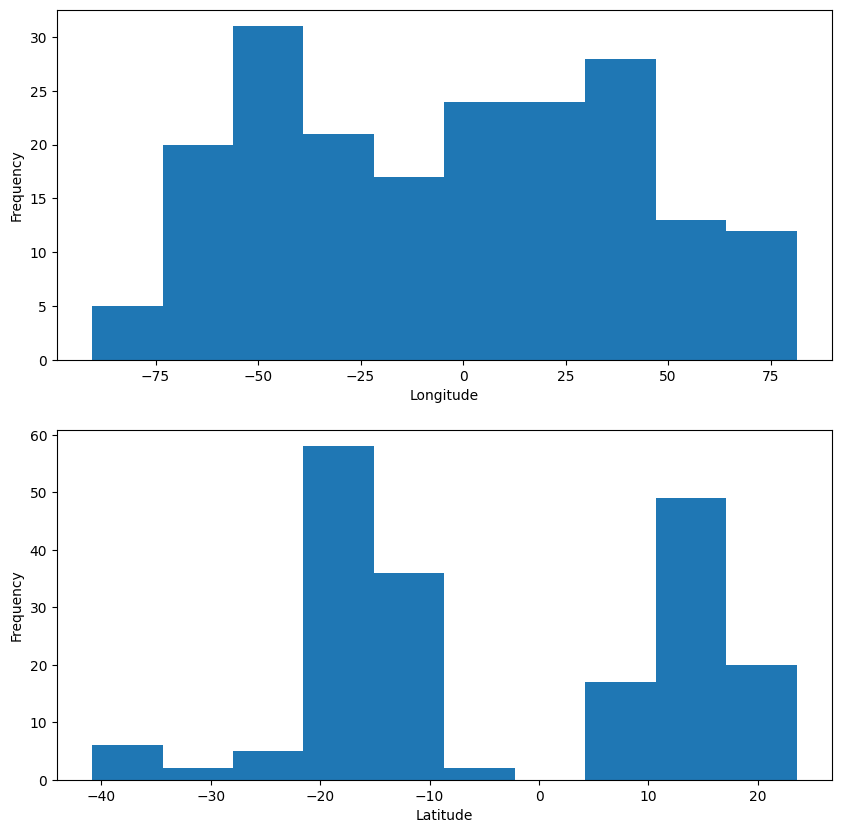

In [66]:
# Plot distribution of longitude and latitude

cur.execute("SELECT longitude, latitude FROM matches_with_coordinates")
coordinates = cur.fetchall()
coordinates = np.array(coordinates)

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.hist(coordinates[:, 0], bins=10)
plt.xlabel("Longitude")
plt.ylabel("Frequency")

plt.subplot(2, 1, 2)
plt.hist(coordinates[:, 1], bins=10)
plt.xlabel("Latitude")
plt.ylabel("Frequency")


In [113]:
# HOw many cmes there are, print with message
cur.execute("SELECT COUNT(*) FROM cmes")
print("There are {} CMEs in the database.".format(cur.fetchone()[0]))

# Now flares, that are not 'Non-verified'
cur.execute("SELECT COUNT(*) FROM flares WHERE flare_class != 'Non-verified'")
print("There are {} flares in the database.".format(cur.fetchone()[0]))

# Now dimmings
cur.execute("SELECT COUNT(*) FROM dimmings")
print("There are {} dimmings in the database.".format(cur.fetchone()[0]))

There are 31944 CMEs in the database.
There are 12580 flares in the database.
There are 2591 dimmings in the database.


In [114]:
# Get all flares scores

cur.execute("SELECT flare_class_score FROM flares")
flare_scores = np.array(cur.fetchall())

# Score 0-9 is class A, score 10-19 is class B, score 20-29 is class C, score 30-39 is class M, score 40- is class X
# Calculate how many flares there are of each class
flare_class_a = np.sum(flare_scores < 10)
flare_class_b = np.sum((flare_scores >= 10) & (flare_scores < 20))
flare_class_c = np.sum((flare_scores >= 20) & (flare_scores < 30))
flare_class_m = np.sum((flare_scores >= 30) & (flare_scores < 40))
flare_class_x = np.sum(flare_scores >= 40)

# Print the results in formatted string
print("There are {} class A flares, {} class B flares, {} class C flares, {} class M flares and {} class X flares.".format(
    flare_class_a, flare_class_b, flare_class_c, flare_class_m, flare_class_x
))


# Now, how many flare with less than 25 and more than 25

cur.execute("SELECT COUNT(*) FROM flares WHERE flare_class_score < 25")
print("There are {} flares with score less than 25.".format(cur.fetchone()[0]))

cur.execute("SELECT COUNT(*) FROM flares WHERE flare_class_score >= 25")
print("There are {} flares with score more than 25.".format(cur.fetchone()[0]))


There are 0 class A flares, 4762 class B flares, 7063 class C flares, 707 class M flares and 48 class X flares.
There are 10918 flares with score less than 25.
There are 1662 flares with score more than 25.


In [118]:
# Number of matches with flare, dimming and flare score more than 25?

cur.execute("""
    SELECT COUNT(*)
    FROM cmes_harpnums
    INNER JOIN cmes ON cmes_harpnums.cme_id = cmes.cme_id
    INNER JOIN flares ON cmes_harpnums.flare_id = flares.flare_id
    WHERE cmes_harpnums.flare_id IS NOT NULL AND cmes_harpnums.dimming_id IS NOT NULL AND flares.flare_class_score > 25 AND harps_spat_consist = 1
""")

print("There are {} matches with flare, dimming and flare score more than 25.".format(cur.fetchone()[0]))

There are 155 matches with flare, dimming and flare score more than 25.


In [121]:
# Now with dimming, flare but flare score less than 25

cur.execute("""
    SELECT COUNT(*)
    FROM cmes_harpnums
    INNER JOIN cmes ON cmes_harpnums.cme_id = cmes.cme_id
    INNER JOIN flares ON cmes_harpnums.flare_id = flares.flare_id
    WHERE cmes_harpnums.flare_id IS NOT NULL AND cmes_harpnums.dimming_id IS NOT NULL AND flares.flare_class_score < 25 AND harps_spat_consist = 1
""")

print("There are {} matches with flare, dimming and flare score less than 25.".format(cur.fetchone()[0]))

There are 1083 matches with flare, dimming and flare score less than 25.


In [88]:
# Now with flare but no dimming and class > 25 and < 25

cur.execute("""
    SELECT COUNT(*)
    FROM cmes_harpnums
    INNER JOIN cmes ON cmes_harpnums.cme_id = cmes.cme_id
    INNER JOIN flares ON cmes_harpnums.flare_id = flares.flare_id
    WHERE cmes_harpnums.flare_id IS NOT NULL AND cmes_harpnums.dimming_id IS NULL AND flares.flare_class_score > 25
""")

print("There are {} matches with flare, no dimming and flare score more than 25.".format(cur.fetchone()[0]))

cur.execute("""
    SELECT COUNT(*)
    FROM cmes_harpnums
    INNER JOIN cmes ON cmes_harpnums.cme_id = cmes.cme_id
    INNER JOIN flares ON cmes_harpnums.flare_id = flares.flare_id
    WHERE cmes_harpnums.flare_id IS NOT NULL AND cmes_harpnums.dimming_id IS NULL AND flares.flare_class_score < 25
""")

print("There are {} matches with flare, no dimming and flare score less than 25.".format(cur.fetchone()[0]))

There are 336 matches with flare, no dimming and flare score more than 25.
There are 1401 matches with flare, no dimming and flare score less than 25.


In [91]:
# And now dimming with no flare

cur.execute("""
    SELECT COUNT(*)
    FROM cmes_harpnums
    INNER JOIN cmes ON cmes_harpnums.cme_id = cmes.cme_id
    INNER JOIN flares ON cmes_harpnums.flare_id = flares.flare_id
    WHERE cmes_harpnums.flare_id IS NULL AND cmes_harpnums.dimming_id IS NOT NULL
""")
print("There are {} matches with dimming and no flare.".format(cur.fetchone()[0]))

There are 0 matches with dimming and no flare.
